In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-06-28 21:53:49.267614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 21:53:49.267670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scGEM'
modality_names = ['Gene Expression', 'DNA Methylation']
data1 = np.loadtxt("../data/UnionCom/scGEM/GeneExpression.txt")
data2 = np.loadtxt("../data/UnionCom/scGEM/DNAmethylation.txt")
type1 = np.loadtxt("../data/UnionCom/scGEM/type1.txt")
type2 = np.loadtxt("../data/UnionCom/scGEM/type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)

# To H5
# pd.DataFrame(data1).to_hdf('../data/' + dataset_name + '.h5', 'data1')
# pd.DataFrame(data2).to_hdf('../data/' + dataset_name + '.h5', 'data2')

# Sampling
# idx = np.random.choice(range(data1.shape[0]), 50, replace=False)
# data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Labels
type_func = lambda x: {1:'BJ', 2:'d8', 3:'d16T+', 4:'d24T+', 5:'IPS'}[x]
labels = [np.array([type_func(j) for j in i]) for i in (type1,type2)]
features = [None, None]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [5]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 100
pca_dim = None

# ComManDo

In [6]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.9016 alpha:3.3532
epoch:[1000/2000] err:0.8065 alpha:3.4468
epoch:[1500/2000] err:0.7737 alpha:3.4895
epoch:[2000/2000] err:0.7415 alpha:3.5167
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.732810
epoch:[1000/2000]: loss:0.578290
epoch:[1500/2000]: loss:0.588912
epoch:[2000/2000]: loss:0.526271
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.026256070001181797
Correspondence: 1.9504659689991968
Mapping: 12.561216604999572
Total: 14.53793864399995

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.747596
epoch:[1000/2000]: loss:0.548526
epoch:[1500/2000]: loss:0.525487
epoch:[2000/2000

In [7]:
# Imputation
cm_imputed = [cm.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

# Comparison Methods

In [8]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [9]:
# NN
nn_imputed = [predict_nn(torch.tensor(dataset[i]).float(), torch.tensor(dataset[(i+1)%2]).float()) for i in range(1, -1, -1)]

# Visualization

In [10]:
integrated_data = [cm_data, nlma_data, lma_data, cca_data]
integrated_names = ['JAMIE', 'Nonlinear Manifold\nAlignment', 'Linear Manifold\nAlignment', 'CCA']
imputed_data = [cm_imputed, nn_imputed]
imputed_names = ['JAMIE', 'NN']
colors = ['blue', 'red', 'green', 'm']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})

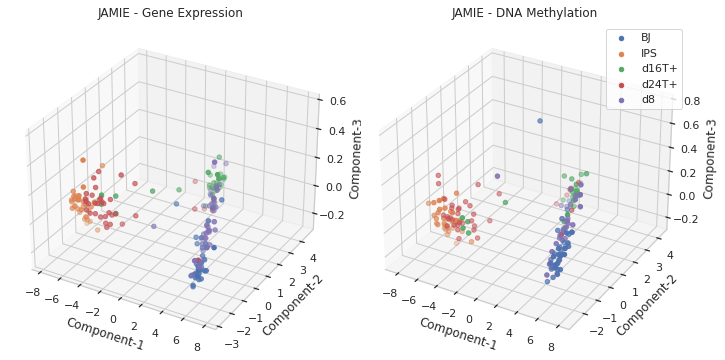

In [11]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

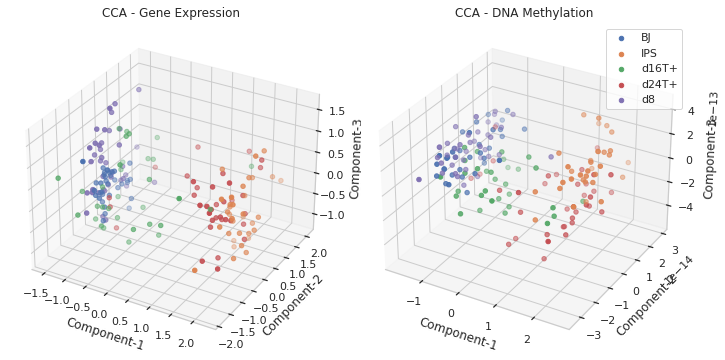

In [12]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cca_data, labels, ['CCA - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-CCA.png')

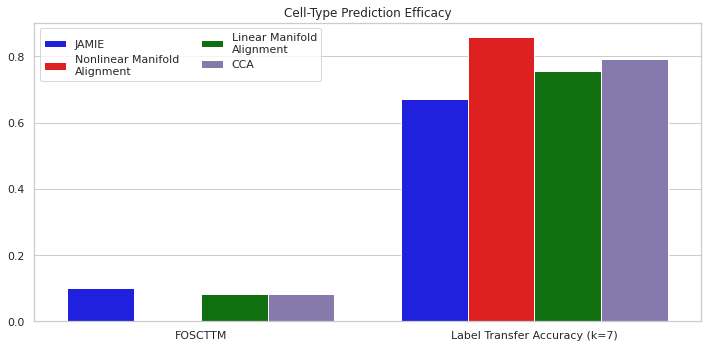

In [13]:
plt.figure(figsize=(10, 5))
plot_accuracy(integrated_data, labels, integrated_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

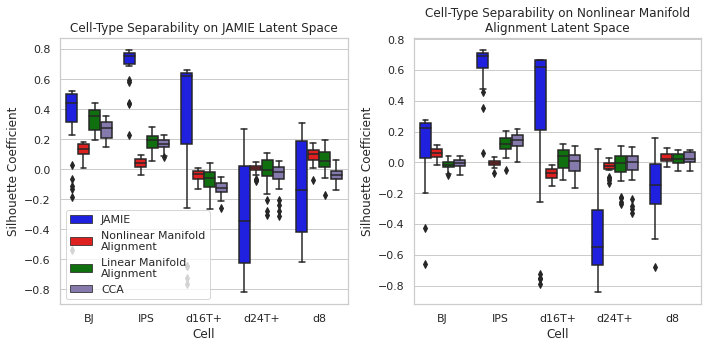

In [14]:
plt.figure(figsize=(10, 5))
plot_silhouette(integrated_data, labels, integrated_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

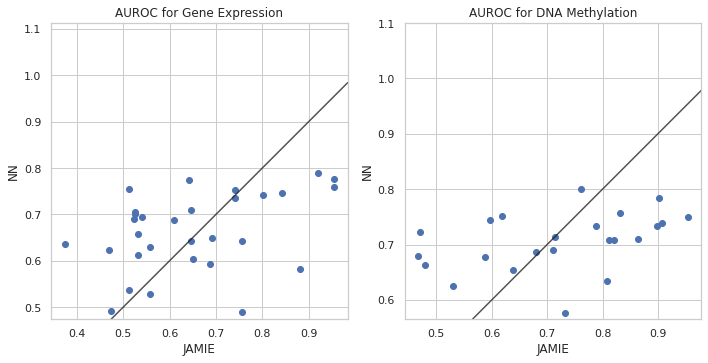

In [15]:
plt.figure(figsize=(10, 5))
plot_auroc(imputed_data, dataset, modality_names, imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Impute.png')

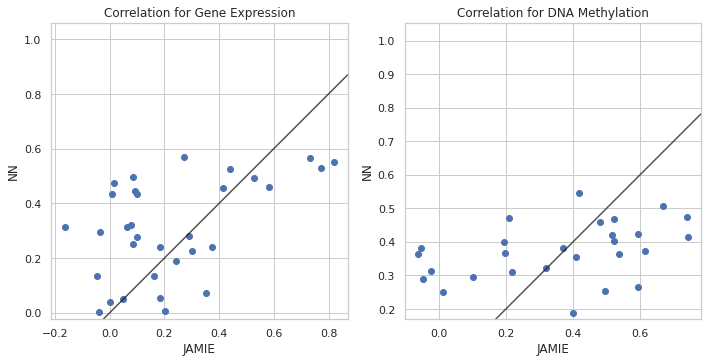

In [16]:
plt.figure(figsize=(10, 5))
plot_correlation(imputed_data, dataset, modality_names, imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Corr.png')